In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import dataloader 
from tqdm import tqdm

In [2]:
import torch.nn as nn
from DeepConvNet_ReLU import DeepConvNet_ReLU
from DeepConvNet_LeakyReLU import DeepConvNet_LeakyReLU
from DeepConvNet_ELU import DeepConvNet_ELU
from EEGNet_ReLU import EEGNet_ReLU
from EEGNet_LeakyReLU import EEGNet_LeakyReLU
from EEGNet_ELU import  EEGNet_ELU

In [3]:
class BCIDataset(Dataset):

    def __init__(self, x, y= None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]
        
    def __len__(self):
        return len(self.x)

In [4]:
def show_model(model):

    for name, parameters in model.named_parameters():
        print(name, ":", parameters.size())

    print(f"\ntotal parameters {sum(p.numel() for p in model.parameters())}")

In [5]:
def trainer(model, train_loader, test_loader, config):
    
    n_epochs = config["n_epochs"]
    device = config["device"]
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= config["learning_rate"])
    
    best_acc = 0
    history = {"loss": [], "acc": [], "test_loss": [], "test_acc": []}

    early_stop = 0
    for epoch in range(n_epochs):
        early_stop += 1
        #training
        model.train()

        batch_train_loss = []
        batch_train_acc = []

        for batch in tqdm(train_loader):

            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(features)
            loss = criterion(pred, labels.long())
            loss.backward()
            optimizer.step()

            acc = (pred.argmax(dim= -1) == labels).float().mean()

            batch_train_loss.append(loss.item())
            batch_train_acc.append(acc)


        train_loss = sum(batch_train_loss) / len(batch_train_loss)
        train_acc = sum(batch_train_acc) / len(batch_train_acc)
        history["loss"].append(train_loss)
        history["acc"].append(train_acc)

        # validation
        model.eval()
        
        batch_test_loss = []
        batch_test_acc = []

        with torch.no_grad():
            
            for batch in tqdm(test_loader):

                features, labels = batch
                labels = labels.to(device)
                test_pred = model(features.to(device))
                loss = criterion(test_pred, labels.long())
                acc = (test_pred.argmax(dim= -1) == labels).float().mean()

                batch_test_acc.append(acc)
                batch_test_loss.append(loss.item())

            test_loss = sum(batch_test_loss) / len(batch_test_loss)
            test_acc = sum(batch_test_acc) / len(batch_test_acc)
            history["test_loss"].append(test_loss)
            history["test_acc"].append(test_acc)
            
            print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f} [ Test | {epoch + 1:03d}/{n_epochs:03d} ] loss = {test_loss:.5f}, test_acc = {test_acc:.5f}")

        if test_acc > best_acc:
            print(f"Best model found at epoch {epoch}, saving model")
            torch.save(model.state_dict(), config["model_save_path"])
            best_acc = test_acc
            early_stop = 0
        if early_stop > config["early_stop"]:
            print("Early Stop!")
            break
    
    return model, history


In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda:0


In [7]:
# hyperparameter
config = {
    "n_epochs" : 400,
    "learning_rate" : 1e-2, # 1e-2
    "batch_size" : 20,
    "device" : device,
    "model" : EEGNet_ReLU(),
    "model_name": "EEGNet_ReLU",
    "model_save_path" : "./best.ckpt",
    "early_stop" : 150
}

In [8]:
import gc 
# load data
train_X, train_y, test_X, test_y = dataloader.read_bci_data()
print(train_X.shape, test_X.shape)

# get dataset
train_set = BCIDataset(train_X, train_y)
test_set = BCIDataset(test_X, test_y)

del train_X, train_y, test_X, test_y
gc.collect()

train_loader = DataLoader(train_set, batch_size= config["batch_size"], shuffle= True)
test_loader = DataLoader(test_set, batch_size= config["batch_size"], shuffle= False)

(1080, 1, 2, 750) (1080, 1, 2, 750)


In [9]:

model = config['model'].to(device)
config["model_save_path"] = f"./{config['model_name']}_best.ckpt"
show_model(model)


first_conv2d.0.weight : torch.Size([8, 1, 1, 51])
first_conv2d.1.weight : torch.Size([8])
first_conv2d.1.bias : torch.Size([8])
depthwise_conv2d.0.weight : torch.Size([8, 2, 2, 1])
depthwise_conv2d.1.weight : torch.Size([8])
depthwise_conv2d.1.bias : torch.Size([8])
separable_conv2d.0.weight : torch.Size([8, 8, 1, 15])
separable_conv2d.1.weight : torch.Size([8])
separable_conv2d.1.bias : torch.Size([8])
fc.0.weight : torch.Size([2, 184])
fc.0.bias : torch.Size([2])

total parameters 1818


In [10]:
model, history = trainer(model, train_loader, test_loader, config) 

100%|██████████| 54/54 [00:00<00:00, 584.48it/s]


[ Train | 001/400 ] loss = 0.63664, acc = 0.69630 [ Test | 001/400 ] loss = 0.58283, test_acc = 0.69630
Best model found at epoch 0, saving model


100%|██████████| 54/54 [00:00<00:00, 631.43it/s]


[ Train | 002/400 ] loss = 0.57912, acc = 0.70000 [ Test | 002/400 ] loss = 0.57247, test_acc = 0.70093
Best model found at epoch 1, saving model


100%|██████████| 54/54 [00:00<00:00, 561.36it/s]


[ Train | 003/400 ] loss = 0.55955, acc = 0.71759 [ Test | 003/400 ] loss = 0.54841, test_acc = 0.71111
Best model found at epoch 2, saving model


100%|██████████| 54/54 [00:00<00:00, 649.38it/s]


[ Train | 004/400 ] loss = 0.56616, acc = 0.70370 [ Test | 004/400 ] loss = 0.55113, test_acc = 0.70833


100%|██████████| 54/54 [00:00<00:00, 664.33it/s]


[ Train | 005/400 ] loss = 0.55933, acc = 0.70556 [ Test | 005/400 ] loss = 0.53967, test_acc = 0.72315
Best model found at epoch 4, saving model


100%|██████████| 54/54 [00:00<00:00, 612.48it/s]


[ Train | 006/400 ] loss = 0.54790, acc = 0.72778 [ Test | 006/400 ] loss = 0.54444, test_acc = 0.71759


100%|██████████| 54/54 [00:00<00:00, 672.73it/s]


[ Train | 007/400 ] loss = 0.54559, acc = 0.71944 [ Test | 007/400 ] loss = 0.53803, test_acc = 0.72130


100%|██████████| 54/54 [00:00<00:00, 678.03it/s]


[ Train | 008/400 ] loss = 0.54239, acc = 0.71389 [ Test | 008/400 ] loss = 0.56488, test_acc = 0.71296


100%|██████████| 54/54 [00:00<00:00, 594.66it/s]


[ Train | 009/400 ] loss = 0.54343, acc = 0.72407 [ Test | 009/400 ] loss = 0.53874, test_acc = 0.72222


100%|██████████| 54/54 [00:00<00:00, 690.17it/s]


[ Train | 010/400 ] loss = 0.53395, acc = 0.72037 [ Test | 010/400 ] loss = 0.54555, test_acc = 0.71481


100%|██████████| 54/54 [00:00<00:00, 646.74it/s]


[ Train | 011/400 ] loss = 0.53614, acc = 0.71944 [ Test | 011/400 ] loss = 0.53485, test_acc = 0.71481


100%|██████████| 54/54 [00:00<00:00, 708.11it/s]


[ Train | 012/400 ] loss = 0.52980, acc = 0.73426 [ Test | 012/400 ] loss = 0.53748, test_acc = 0.71944


100%|██████████| 54/54 [00:00<00:00, 660.19it/s]


[ Train | 013/400 ] loss = 0.52565, acc = 0.73426 [ Test | 013/400 ] loss = 0.53411, test_acc = 0.71481


100%|██████████| 54/54 [00:00<00:00, 635.60it/s]


[ Train | 014/400 ] loss = 0.53883, acc = 0.71111 [ Test | 014/400 ] loss = 0.53245, test_acc = 0.71759


100%|██████████| 54/54 [00:00<00:00, 540.14it/s]


[ Train | 015/400 ] loss = 0.51847, acc = 0.73611 [ Test | 015/400 ] loss = 0.55376, test_acc = 0.72407
Best model found at epoch 14, saving model


100%|██████████| 54/54 [00:00<00:00, 550.01it/s]


[ Train | 016/400 ] loss = 0.52546, acc = 0.72870 [ Test | 016/400 ] loss = 0.54936, test_acc = 0.71296


100%|██████████| 54/54 [00:00<00:00, 683.33it/s]


[ Train | 017/400 ] loss = 0.52187, acc = 0.72778 [ Test | 017/400 ] loss = 0.53401, test_acc = 0.71852


100%|██████████| 54/54 [00:00<00:00, 585.05it/s]


[ Train | 018/400 ] loss = 0.53809, acc = 0.73981 [ Test | 018/400 ] loss = 0.53973, test_acc = 0.71759


100%|██████████| 54/54 [00:00<00:00, 671.00it/s]


[ Train | 019/400 ] loss = 0.52149, acc = 0.74444 [ Test | 019/400 ] loss = 0.52546, test_acc = 0.73333
Best model found at epoch 18, saving model


100%|██████████| 54/54 [00:00<00:00, 491.51it/s]


[ Train | 020/400 ] loss = 0.51905, acc = 0.72315 [ Test | 020/400 ] loss = 0.54116, test_acc = 0.73426
Best model found at epoch 19, saving model


100%|██████████| 54/54 [00:00<00:00, 622.42it/s]


[ Train | 021/400 ] loss = 0.51929, acc = 0.73241 [ Test | 021/400 ] loss = 0.53494, test_acc = 0.72593


100%|██████████| 54/54 [00:00<00:00, 572.45it/s]


[ Train | 022/400 ] loss = 0.52167, acc = 0.73796 [ Test | 022/400 ] loss = 0.52607, test_acc = 0.72963


100%|██████████| 54/54 [00:00<00:00, 600.43it/s]


[ Train | 023/400 ] loss = 0.52208, acc = 0.74537 [ Test | 023/400 ] loss = 0.53273, test_acc = 0.74537
Best model found at epoch 22, saving model


100%|██████████| 54/54 [00:00<00:00, 594.20it/s]


[ Train | 024/400 ] loss = 0.52124, acc = 0.74074 [ Test | 024/400 ] loss = 0.52306, test_acc = 0.74444


100%|██████████| 54/54 [00:00<00:00, 474.27it/s]


[ Train | 025/400 ] loss = 0.53074, acc = 0.71667 [ Test | 025/400 ] loss = 0.52962, test_acc = 0.72500


100%|██████████| 54/54 [00:00<00:00, 654.76it/s]


[ Train | 026/400 ] loss = 0.51203, acc = 0.74815 [ Test | 026/400 ] loss = 0.53365, test_acc = 0.73426


100%|██████████| 54/54 [00:00<00:00, 590.71it/s]


[ Train | 027/400 ] loss = 0.52498, acc = 0.73333 [ Test | 027/400 ] loss = 0.53239, test_acc = 0.72130


100%|██████████| 54/54 [00:00<00:00, 645.52it/s]


[ Train | 028/400 ] loss = 0.53386, acc = 0.73426 [ Test | 028/400 ] loss = 0.53228, test_acc = 0.72778


100%|██████████| 54/54 [00:00<00:00, 549.56it/s]


[ Train | 029/400 ] loss = 0.52405, acc = 0.73519 [ Test | 029/400 ] loss = 0.52613, test_acc = 0.73704


100%|██████████| 54/54 [00:00<00:00, 504.06it/s]


[ Train | 030/400 ] loss = 0.51708, acc = 0.73981 [ Test | 030/400 ] loss = 0.52629, test_acc = 0.73241


100%|██████████| 54/54 [00:00<00:00, 588.41it/s]


[ Train | 031/400 ] loss = 0.52752, acc = 0.72407 [ Test | 031/400 ] loss = 0.52475, test_acc = 0.74444


100%|██████████| 54/54 [00:00<00:00, 565.32it/s]


[ Train | 032/400 ] loss = 0.49779, acc = 0.74722 [ Test | 032/400 ] loss = 0.53170, test_acc = 0.74537


100%|██████████| 54/54 [00:00<00:00, 590.62it/s]


[ Train | 033/400 ] loss = 0.51030, acc = 0.75093 [ Test | 033/400 ] loss = 0.52108, test_acc = 0.73981


100%|██████████| 54/54 [00:00<00:00, 607.39it/s]


[ Train | 034/400 ] loss = 0.49711, acc = 0.73426 [ Test | 034/400 ] loss = 0.53791, test_acc = 0.72963


100%|██████████| 54/54 [00:00<00:00, 433.84it/s]


[ Train | 035/400 ] loss = 0.52295, acc = 0.73889 [ Test | 035/400 ] loss = 0.53230, test_acc = 0.74074


100%|██████████| 54/54 [00:00<00:00, 642.18it/s]


[ Train | 036/400 ] loss = 0.51243, acc = 0.73889 [ Test | 036/400 ] loss = 0.52684, test_acc = 0.72778


100%|██████████| 54/54 [00:00<00:00, 609.99it/s]


[ Train | 037/400 ] loss = 0.52308, acc = 0.73241 [ Test | 037/400 ] loss = 0.53038, test_acc = 0.72130


100%|██████████| 54/54 [00:00<00:00, 572.80it/s]


[ Train | 038/400 ] loss = 0.51451, acc = 0.73889 [ Test | 038/400 ] loss = 0.53304, test_acc = 0.73889


100%|██████████| 54/54 [00:00<00:00, 640.58it/s]


[ Train | 039/400 ] loss = 0.51746, acc = 0.73241 [ Test | 039/400 ] loss = 0.53325, test_acc = 0.73333


100%|██████████| 54/54 [00:00<00:00, 566.54it/s]


[ Train | 040/400 ] loss = 0.51985, acc = 0.73333 [ Test | 040/400 ] loss = 0.52212, test_acc = 0.74167


100%|██████████| 54/54 [00:00<00:00, 543.12it/s]


[ Train | 041/400 ] loss = 0.51743, acc = 0.73796 [ Test | 041/400 ] loss = 0.53474, test_acc = 0.72037


100%|██████████| 54/54 [00:00<00:00, 600.53it/s]


[ Train | 042/400 ] loss = 0.50847, acc = 0.75556 [ Test | 042/400 ] loss = 0.53832, test_acc = 0.72963


100%|██████████| 54/54 [00:00<00:00, 549.17it/s]


[ Train | 043/400 ] loss = 0.49945, acc = 0.73519 [ Test | 043/400 ] loss = 0.53798, test_acc = 0.72500


100%|██████████| 54/54 [00:00<00:00, 552.96it/s]


[ Train | 044/400 ] loss = 0.52916, acc = 0.72778 [ Test | 044/400 ] loss = 0.53019, test_acc = 0.73241


100%|██████████| 54/54 [00:00<00:00, 573.65it/s]


[ Train | 045/400 ] loss = 0.52157, acc = 0.73056 [ Test | 045/400 ] loss = 0.52650, test_acc = 0.73426


100%|██████████| 54/54 [00:00<00:00, 677.15it/s]


[ Train | 046/400 ] loss = 0.49928, acc = 0.75093 [ Test | 046/400 ] loss = 0.53408, test_acc = 0.73889


100%|██████████| 54/54 [00:00<00:00, 573.80it/s]


[ Train | 047/400 ] loss = 0.49416, acc = 0.73611 [ Test | 047/400 ] loss = 0.55655, test_acc = 0.72870


100%|██████████| 54/54 [00:00<00:00, 552.08it/s]


[ Train | 048/400 ] loss = 0.51239, acc = 0.73519 [ Test | 048/400 ] loss = 0.53740, test_acc = 0.73333


100%|██████████| 54/54 [00:00<00:00, 592.85it/s]


[ Train | 049/400 ] loss = 0.50026, acc = 0.75185 [ Test | 049/400 ] loss = 0.53342, test_acc = 0.73796


100%|██████████| 54/54 [00:00<00:00, 620.63it/s]


[ Train | 050/400 ] loss = 0.50672, acc = 0.73333 [ Test | 050/400 ] loss = 0.53369, test_acc = 0.73611


100%|██████████| 54/54 [00:00<00:00, 606.48it/s]


[ Train | 051/400 ] loss = 0.51932, acc = 0.74815 [ Test | 051/400 ] loss = 0.52960, test_acc = 0.73981


100%|██████████| 54/54 [00:00<00:00, 607.22it/s]


[ Train | 052/400 ] loss = 0.49586, acc = 0.74907 [ Test | 052/400 ] loss = 0.52831, test_acc = 0.72778


100%|██████████| 54/54 [00:00<00:00, 529.52it/s]


[ Train | 053/400 ] loss = 0.51398, acc = 0.73889 [ Test | 053/400 ] loss = 0.53603, test_acc = 0.72778


100%|██████████| 54/54 [00:00<00:00, 490.28it/s]


[ Train | 054/400 ] loss = 0.50340, acc = 0.75185 [ Test | 054/400 ] loss = 0.52922, test_acc = 0.73704


100%|██████████| 54/54 [00:00<00:00, 613.70it/s]


[ Train | 055/400 ] loss = 0.49445, acc = 0.74352 [ Test | 055/400 ] loss = 0.52771, test_acc = 0.73611


100%|██████████| 54/54 [00:00<00:00, 568.36it/s]


[ Train | 056/400 ] loss = 0.51291, acc = 0.74167 [ Test | 056/400 ] loss = 0.53896, test_acc = 0.72130


100%|██████████| 54/54 [00:00<00:00, 660.87it/s]


[ Train | 057/400 ] loss = 0.51559, acc = 0.72963 [ Test | 057/400 ] loss = 0.53854, test_acc = 0.72315


100%|██████████| 54/54 [00:00<00:00, 523.42it/s]


[ Train | 058/400 ] loss = 0.50370, acc = 0.73796 [ Test | 058/400 ] loss = 0.53636, test_acc = 0.73426


100%|██████████| 54/54 [00:00<00:00, 558.71it/s]


[ Train | 059/400 ] loss = 0.49793, acc = 0.75370 [ Test | 059/400 ] loss = 0.53756, test_acc = 0.73333


100%|██████████| 54/54 [00:00<00:00, 630.31it/s]


[ Train | 060/400 ] loss = 0.50417, acc = 0.74537 [ Test | 060/400 ] loss = 0.52983, test_acc = 0.74167


100%|██████████| 54/54 [00:00<00:00, 618.31it/s]


[ Train | 061/400 ] loss = 0.50745, acc = 0.73796 [ Test | 061/400 ] loss = 0.53797, test_acc = 0.73056


100%|██████████| 54/54 [00:00<00:00, 557.75it/s]


[ Train | 062/400 ] loss = 0.48997, acc = 0.74537 [ Test | 062/400 ] loss = 0.53608, test_acc = 0.72870


100%|██████████| 54/54 [00:00<00:00, 700.41it/s]


[ Train | 063/400 ] loss = 0.49148, acc = 0.75093 [ Test | 063/400 ] loss = 0.53277, test_acc = 0.73148


100%|██████████| 54/54 [00:00<00:00, 642.41it/s]


[ Train | 064/400 ] loss = 0.49535, acc = 0.77130 [ Test | 064/400 ] loss = 0.52461, test_acc = 0.74259


100%|██████████| 54/54 [00:00<00:00, 593.17it/s]


[ Train | 065/400 ] loss = 0.49274, acc = 0.75556 [ Test | 065/400 ] loss = 0.52476, test_acc = 0.73704


100%|██████████| 54/54 [00:00<00:00, 648.73it/s]


[ Train | 066/400 ] loss = 0.51870, acc = 0.75556 [ Test | 066/400 ] loss = 0.53835, test_acc = 0.71852


100%|██████████| 54/54 [00:00<00:00, 567.01it/s]


[ Train | 067/400 ] loss = 0.49022, acc = 0.75370 [ Test | 067/400 ] loss = 0.51964, test_acc = 0.74352


100%|██████████| 54/54 [00:00<00:00, 584.76it/s]


[ Train | 068/400 ] loss = 0.50858, acc = 0.74167 [ Test | 068/400 ] loss = 0.52126, test_acc = 0.75278
Best model found at epoch 67, saving model


100%|██████████| 54/54 [00:00<00:00, 628.81it/s]


[ Train | 069/400 ] loss = 0.48091, acc = 0.76204 [ Test | 069/400 ] loss = 0.50890, test_acc = 0.76574
Best model found at epoch 68, saving model


100%|██████████| 54/54 [00:00<00:00, 557.30it/s]


[ Train | 070/400 ] loss = 0.48642, acc = 0.76481 [ Test | 070/400 ] loss = 0.50806, test_acc = 0.77130
Best model found at epoch 69, saving model


100%|██████████| 54/54 [00:00<00:00, 595.20it/s]


[ Train | 071/400 ] loss = 0.47873, acc = 0.77593 [ Test | 071/400 ] loss = 0.50086, test_acc = 0.77500
Best model found at epoch 70, saving model


100%|██████████| 54/54 [00:00<00:00, 641.48it/s]


[ Train | 072/400 ] loss = 0.46827, acc = 0.78704 [ Test | 072/400 ] loss = 0.50657, test_acc = 0.77315


100%|██████████| 54/54 [00:00<00:00, 666.02it/s]


[ Train | 073/400 ] loss = 0.48521, acc = 0.76667 [ Test | 073/400 ] loss = 0.48720, test_acc = 0.76852


100%|██████████| 54/54 [00:00<00:00, 660.97it/s]


[ Train | 074/400 ] loss = 0.47361, acc = 0.77315 [ Test | 074/400 ] loss = 0.48914, test_acc = 0.77315


100%|██████████| 54/54 [00:00<00:00, 584.85it/s]


[ Train | 075/400 ] loss = 0.46653, acc = 0.78056 [ Test | 075/400 ] loss = 0.48738, test_acc = 0.77222


100%|██████████| 54/54 [00:00<00:00, 501.74it/s]


[ Train | 076/400 ] loss = 0.47331, acc = 0.78704 [ Test | 076/400 ] loss = 0.47915, test_acc = 0.77870
Best model found at epoch 75, saving model


100%|██████████| 54/54 [00:00<00:00, 607.56it/s]


[ Train | 077/400 ] loss = 0.47162, acc = 0.79259 [ Test | 077/400 ] loss = 0.48192, test_acc = 0.77870


100%|██████████| 54/54 [00:00<00:00, 568.77it/s]


[ Train | 078/400 ] loss = 0.46505, acc = 0.78611 [ Test | 078/400 ] loss = 0.48706, test_acc = 0.78241
Best model found at epoch 77, saving model


100%|██████████| 54/54 [00:00<00:00, 646.71it/s]


[ Train | 079/400 ] loss = 0.46768, acc = 0.78333 [ Test | 079/400 ] loss = 0.47878, test_acc = 0.79167
Best model found at epoch 78, saving model


100%|██████████| 54/54 [00:00<00:00, 619.96it/s]


[ Train | 080/400 ] loss = 0.45781, acc = 0.78519 [ Test | 080/400 ] loss = 0.47476, test_acc = 0.77778


100%|██████████| 54/54 [00:00<00:00, 556.11it/s]


[ Train | 081/400 ] loss = 0.47106, acc = 0.78056 [ Test | 081/400 ] loss = 0.48683, test_acc = 0.76852


100%|██████████| 54/54 [00:00<00:00, 569.91it/s]


[ Train | 082/400 ] loss = 0.46034, acc = 0.78981 [ Test | 082/400 ] loss = 0.46775, test_acc = 0.78611


100%|██████████| 54/54 [00:00<00:00, 637.84it/s]


[ Train | 083/400 ] loss = 0.44447, acc = 0.78889 [ Test | 083/400 ] loss = 0.45872, test_acc = 0.78611


100%|██████████| 54/54 [00:00<00:00, 549.25it/s]


[ Train | 084/400 ] loss = 0.43803, acc = 0.81204 [ Test | 084/400 ] loss = 0.48857, test_acc = 0.76667


100%|██████████| 54/54 [00:00<00:00, 633.13it/s]


[ Train | 085/400 ] loss = 0.44019, acc = 0.79630 [ Test | 085/400 ] loss = 0.46605, test_acc = 0.79074


100%|██████████| 54/54 [00:00<00:00, 580.64it/s]


[ Train | 086/400 ] loss = 0.45769, acc = 0.78981 [ Test | 086/400 ] loss = 0.44808, test_acc = 0.79352
Best model found at epoch 85, saving model


100%|██████████| 54/54 [00:00<00:00, 643.61it/s]


[ Train | 087/400 ] loss = 0.44843, acc = 0.78889 [ Test | 087/400 ] loss = 0.48161, test_acc = 0.78611


100%|██████████| 54/54 [00:00<00:00, 667.85it/s]


[ Train | 088/400 ] loss = 0.45747, acc = 0.79630 [ Test | 088/400 ] loss = 0.46592, test_acc = 0.77593


100%|██████████| 54/54 [00:00<00:00, 640.58it/s]


[ Train | 089/400 ] loss = 0.42903, acc = 0.80370 [ Test | 089/400 ] loss = 0.45169, test_acc = 0.79722
Best model found at epoch 88, saving model


100%|██████████| 54/54 [00:00<00:00, 630.24it/s]


[ Train | 090/400 ] loss = 0.45005, acc = 0.78241 [ Test | 090/400 ] loss = 0.44463, test_acc = 0.79907
Best model found at epoch 89, saving model


100%|██████████| 54/54 [00:00<00:00, 574.52it/s]


[ Train | 091/400 ] loss = 0.43738, acc = 0.79907 [ Test | 091/400 ] loss = 0.45999, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 607.37it/s]


[ Train | 092/400 ] loss = 0.43321, acc = 0.80278 [ Test | 092/400 ] loss = 0.45160, test_acc = 0.79074


100%|██████████| 54/54 [00:00<00:00, 587.60it/s]


[ Train | 093/400 ] loss = 0.42811, acc = 0.79630 [ Test | 093/400 ] loss = 0.47524, test_acc = 0.78426


100%|██████████| 54/54 [00:00<00:00, 573.29it/s]


[ Train | 094/400 ] loss = 0.44754, acc = 0.79722 [ Test | 094/400 ] loss = 0.44727, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 513.02it/s]


[ Train | 095/400 ] loss = 0.43386, acc = 0.80185 [ Test | 095/400 ] loss = 0.44668, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 516.01it/s]


[ Train | 096/400 ] loss = 0.43490, acc = 0.79352 [ Test | 096/400 ] loss = 0.44326, test_acc = 0.80000
Best model found at epoch 95, saving model


100%|██████████| 54/54 [00:00<00:00, 704.20it/s]


[ Train | 097/400 ] loss = 0.41684, acc = 0.80556 [ Test | 097/400 ] loss = 0.44048, test_acc = 0.80556
Best model found at epoch 96, saving model


100%|██████████| 54/54 [00:00<00:00, 557.11it/s]


[ Train | 098/400 ] loss = 0.42264, acc = 0.81019 [ Test | 098/400 ] loss = 0.44202, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 584.16it/s]


[ Train | 099/400 ] loss = 0.43811, acc = 0.80093 [ Test | 099/400 ] loss = 0.45177, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 672.41it/s]


[ Train | 100/400 ] loss = 0.43451, acc = 0.79074 [ Test | 100/400 ] loss = 0.43449, test_acc = 0.80741
Best model found at epoch 99, saving model


100%|██████████| 54/54 [00:00<00:00, 611.65it/s]


[ Train | 101/400 ] loss = 0.43590, acc = 0.81204 [ Test | 101/400 ] loss = 0.46876, test_acc = 0.78519


100%|██████████| 54/54 [00:00<00:00, 472.94it/s]


[ Train | 102/400 ] loss = 0.43538, acc = 0.80556 [ Test | 102/400 ] loss = 0.43558, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 617.39it/s]


[ Train | 103/400 ] loss = 0.42100, acc = 0.81944 [ Test | 103/400 ] loss = 0.47181, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 598.75it/s]


[ Train | 104/400 ] loss = 0.41908, acc = 0.80185 [ Test | 104/400 ] loss = 0.45633, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 530.39it/s]


[ Train | 105/400 ] loss = 0.43552, acc = 0.80741 [ Test | 105/400 ] loss = 0.43396, test_acc = 0.80741
Best model found at epoch 104, saving model


100%|██████████| 54/54 [00:00<00:00, 616.27it/s]


[ Train | 106/400 ] loss = 0.44474, acc = 0.78519 [ Test | 106/400 ] loss = 0.45656, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 647.97it/s]


[ Train | 107/400 ] loss = 0.42171, acc = 0.80741 [ Test | 107/400 ] loss = 0.47287, test_acc = 0.78333


100%|██████████| 54/54 [00:00<00:00, 613.96it/s]


[ Train | 108/400 ] loss = 0.45036, acc = 0.79444 [ Test | 108/400 ] loss = 0.43966, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 517.81it/s]


[ Train | 109/400 ] loss = 0.43927, acc = 0.81204 [ Test | 109/400 ] loss = 0.44696, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 604.29it/s]


[ Train | 110/400 ] loss = 0.42741, acc = 0.79815 [ Test | 110/400 ] loss = 0.43797, test_acc = 0.81111
Best model found at epoch 109, saving model


100%|██████████| 54/54 [00:00<00:00, 676.95it/s]


[ Train | 111/400 ] loss = 0.39279, acc = 0.82778 [ Test | 111/400 ] loss = 0.46108, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 628.07it/s]


[ Train | 112/400 ] loss = 0.43168, acc = 0.80833 [ Test | 112/400 ] loss = 0.44600, test_acc = 0.80000


100%|██████████| 54/54 [00:00<00:00, 605.01it/s]


[ Train | 113/400 ] loss = 0.42730, acc = 0.80370 [ Test | 113/400 ] loss = 0.43242, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 618.67it/s]


[ Train | 114/400 ] loss = 0.40495, acc = 0.82037 [ Test | 114/400 ] loss = 0.47996, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 596.45it/s]


[ Train | 115/400 ] loss = 0.43787, acc = 0.80648 [ Test | 115/400 ] loss = 0.43712, test_acc = 0.81204
Best model found at epoch 114, saving model


100%|██████████| 54/54 [00:00<00:00, 616.98it/s]


[ Train | 116/400 ] loss = 0.42563, acc = 0.81574 [ Test | 116/400 ] loss = 0.43515, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 636.36it/s]


[ Train | 117/400 ] loss = 0.42128, acc = 0.80833 [ Test | 117/400 ] loss = 0.44739, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 541.63it/s]


[ Train | 118/400 ] loss = 0.42282, acc = 0.80648 [ Test | 118/400 ] loss = 0.46335, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 674.18it/s]


[ Train | 119/400 ] loss = 0.43373, acc = 0.81111 [ Test | 119/400 ] loss = 0.47750, test_acc = 0.78889


100%|██████████| 54/54 [00:00<00:00, 687.73it/s]


[ Train | 120/400 ] loss = 0.43348, acc = 0.80185 [ Test | 120/400 ] loss = 0.46774, test_acc = 0.79352


100%|██████████| 54/54 [00:00<00:00, 571.41it/s]


[ Train | 121/400 ] loss = 0.41579, acc = 0.80926 [ Test | 121/400 ] loss = 0.43451, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 534.42it/s]


[ Train | 122/400 ] loss = 0.42069, acc = 0.81667 [ Test | 122/400 ] loss = 0.43541, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 692.66it/s]


[ Train | 123/400 ] loss = 0.43302, acc = 0.79907 [ Test | 123/400 ] loss = 0.44704, test_acc = 0.79259


100%|██████████| 54/54 [00:00<00:00, 611.10it/s]


[ Train | 124/400 ] loss = 0.41808, acc = 0.80556 [ Test | 124/400 ] loss = 0.49705, test_acc = 0.78796


100%|██████████| 54/54 [00:00<00:00, 596.06it/s]


[ Train | 125/400 ] loss = 0.43072, acc = 0.79907 [ Test | 125/400 ] loss = 0.45909, test_acc = 0.78889


100%|██████████| 54/54 [00:00<00:00, 620.57it/s]


[ Train | 126/400 ] loss = 0.43012, acc = 0.80926 [ Test | 126/400 ] loss = 0.45693, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 579.31it/s]


[ Train | 127/400 ] loss = 0.41465, acc = 0.81111 [ Test | 127/400 ] loss = 0.46554, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 561.85it/s]


[ Train | 128/400 ] loss = 0.43795, acc = 0.80463 [ Test | 128/400 ] loss = 0.48094, test_acc = 0.78704


100%|██████████| 54/54 [00:00<00:00, 636.75it/s]


[ Train | 129/400 ] loss = 0.41879, acc = 0.81759 [ Test | 129/400 ] loss = 0.45922, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 586.98it/s]


[ Train | 130/400 ] loss = 0.43074, acc = 0.80093 [ Test | 130/400 ] loss = 0.45280, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 643.94it/s]


[ Train | 131/400 ] loss = 0.41125, acc = 0.80556 [ Test | 131/400 ] loss = 0.44799, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 640.70it/s]


[ Train | 132/400 ] loss = 0.42881, acc = 0.80648 [ Test | 132/400 ] loss = 0.44593, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 599.35it/s]


[ Train | 133/400 ] loss = 0.41134, acc = 0.82315 [ Test | 133/400 ] loss = 0.43813, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 649.21it/s]


[ Train | 134/400 ] loss = 0.43244, acc = 0.81574 [ Test | 134/400 ] loss = 0.43631, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 682.20it/s]


[ Train | 135/400 ] loss = 0.43039, acc = 0.79444 [ Test | 135/400 ] loss = 0.47936, test_acc = 0.78241


100%|██████████| 54/54 [00:00<00:00, 629.37it/s]


[ Train | 136/400 ] loss = 0.40308, acc = 0.82593 [ Test | 136/400 ] loss = 0.43130, test_acc = 0.81296
Best model found at epoch 135, saving model


100%|██████████| 54/54 [00:00<00:00, 473.32it/s]


[ Train | 137/400 ] loss = 0.41767, acc = 0.79907 [ Test | 137/400 ] loss = 0.44521, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 566.15it/s]


[ Train | 138/400 ] loss = 0.42801, acc = 0.81204 [ Test | 138/400 ] loss = 0.43841, test_acc = 0.79074


100%|██████████| 54/54 [00:00<00:00, 604.66it/s]


[ Train | 139/400 ] loss = 0.42442, acc = 0.80370 [ Test | 139/400 ] loss = 0.45385, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 451.63it/s]


[ Train | 140/400 ] loss = 0.42670, acc = 0.80926 [ Test | 140/400 ] loss = 0.44887, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 596.91it/s]


[ Train | 141/400 ] loss = 0.41460, acc = 0.80278 [ Test | 141/400 ] loss = 0.42824, test_acc = 0.81296
Best model found at epoch 140, saving model


100%|██████████| 54/54 [00:00<00:00, 565.91it/s]


[ Train | 142/400 ] loss = 0.42908, acc = 0.81019 [ Test | 142/400 ] loss = 0.44477, test_acc = 0.79259


100%|██████████| 54/54 [00:00<00:00, 556.53it/s]


[ Train | 143/400 ] loss = 0.41867, acc = 0.80463 [ Test | 143/400 ] loss = 0.44709, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 555.07it/s]


[ Train | 144/400 ] loss = 0.42610, acc = 0.80278 [ Test | 144/400 ] loss = 0.44170, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 581.48it/s]


[ Train | 145/400 ] loss = 0.40977, acc = 0.81944 [ Test | 145/400 ] loss = 0.46052, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 568.83it/s]


[ Train | 146/400 ] loss = 0.41211, acc = 0.80370 [ Test | 146/400 ] loss = 0.46701, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 513.23it/s]


[ Train | 147/400 ] loss = 0.42051, acc = 0.81296 [ Test | 147/400 ] loss = 0.47129, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 571.25it/s]


[ Train | 148/400 ] loss = 0.39984, acc = 0.81852 [ Test | 148/400 ] loss = 0.44170, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 576.24it/s]


[ Train | 149/400 ] loss = 0.39883, acc = 0.81574 [ Test | 149/400 ] loss = 0.47045, test_acc = 0.79352


100%|██████████| 54/54 [00:00<00:00, 567.38it/s]


[ Train | 150/400 ] loss = 0.42088, acc = 0.81389 [ Test | 150/400 ] loss = 0.46975, test_acc = 0.78241


100%|██████████| 54/54 [00:00<00:00, 596.12it/s]


[ Train | 151/400 ] loss = 0.42374, acc = 0.81944 [ Test | 151/400 ] loss = 0.45377, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 649.48it/s]


[ Train | 152/400 ] loss = 0.40501, acc = 0.83519 [ Test | 152/400 ] loss = 0.43565, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 588.33it/s]


[ Train | 153/400 ] loss = 0.43788, acc = 0.80000 [ Test | 153/400 ] loss = 0.44450, test_acc = 0.80000


100%|██████████| 54/54 [00:00<00:00, 668.78it/s]


[ Train | 154/400 ] loss = 0.42952, acc = 0.81296 [ Test | 154/400 ] loss = 0.44794, test_acc = 0.79630


100%|██████████| 54/54 [00:00<00:00, 631.42it/s]


[ Train | 155/400 ] loss = 0.41163, acc = 0.81574 [ Test | 155/400 ] loss = 0.46308, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 620.18it/s]


[ Train | 156/400 ] loss = 0.41447, acc = 0.81019 [ Test | 156/400 ] loss = 0.45522, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 556.73it/s]


[ Train | 157/400 ] loss = 0.42238, acc = 0.82037 [ Test | 157/400 ] loss = 0.44071, test_acc = 0.79167


100%|██████████| 54/54 [00:00<00:00, 587.46it/s]


[ Train | 158/400 ] loss = 0.43602, acc = 0.80741 [ Test | 158/400 ] loss = 0.44591, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 608.44it/s]


[ Train | 159/400 ] loss = 0.42501, acc = 0.80926 [ Test | 159/400 ] loss = 0.45688, test_acc = 0.79167


100%|██████████| 54/54 [00:00<00:00, 626.10it/s]


[ Train | 160/400 ] loss = 0.42246, acc = 0.80648 [ Test | 160/400 ] loss = 0.46638, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 607.75it/s]


[ Train | 161/400 ] loss = 0.42228, acc = 0.80833 [ Test | 161/400 ] loss = 0.43988, test_acc = 0.79630


100%|██████████| 54/54 [00:00<00:00, 557.62it/s]


[ Train | 162/400 ] loss = 0.42341, acc = 0.81204 [ Test | 162/400 ] loss = 0.44726, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 601.03it/s]


[ Train | 163/400 ] loss = 0.40406, acc = 0.81759 [ Test | 163/400 ] loss = 0.43537, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 620.24it/s]


[ Train | 164/400 ] loss = 0.40867, acc = 0.81759 [ Test | 164/400 ] loss = 0.43924, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 648.04it/s]


[ Train | 165/400 ] loss = 0.40461, acc = 0.81574 [ Test | 165/400 ] loss = 0.45103, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 460.80it/s]


[ Train | 166/400 ] loss = 0.41454, acc = 0.82407 [ Test | 166/400 ] loss = 0.44783, test_acc = 0.80000


100%|██████████| 54/54 [00:00<00:00, 552.86it/s]


[ Train | 167/400 ] loss = 0.42539, acc = 0.81204 [ Test | 167/400 ] loss = 0.44344, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 677.99it/s]


[ Train | 168/400 ] loss = 0.42025, acc = 0.80000 [ Test | 168/400 ] loss = 0.43893, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 682.96it/s]


[ Train | 169/400 ] loss = 0.43766, acc = 0.81574 [ Test | 169/400 ] loss = 0.46406, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 677.73it/s]


[ Train | 170/400 ] loss = 0.42519, acc = 0.81574 [ Test | 170/400 ] loss = 0.46272, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 572.79it/s]


[ Train | 171/400 ] loss = 0.41428, acc = 0.82407 [ Test | 171/400 ] loss = 0.46235, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 590.90it/s]


[ Train | 172/400 ] loss = 0.40166, acc = 0.82037 [ Test | 172/400 ] loss = 0.45027, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 617.68it/s]


[ Train | 173/400 ] loss = 0.38064, acc = 0.82778 [ Test | 173/400 ] loss = 0.52621, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 581.66it/s]


[ Train | 174/400 ] loss = 0.42452, acc = 0.81852 [ Test | 174/400 ] loss = 0.46179, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 574.74it/s]


[ Train | 175/400 ] loss = 0.42420, acc = 0.80000 [ Test | 175/400 ] loss = 0.44050, test_acc = 0.79352


100%|██████████| 54/54 [00:00<00:00, 699.70it/s]


[ Train | 176/400 ] loss = 0.44048, acc = 0.80093 [ Test | 176/400 ] loss = 0.43432, test_acc = 0.81667
Best model found at epoch 175, saving model


100%|██████████| 54/54 [00:00<00:00, 530.47it/s]


[ Train | 177/400 ] loss = 0.39659, acc = 0.82315 [ Test | 177/400 ] loss = 0.45814, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 567.63it/s]


[ Train | 178/400 ] loss = 0.41783, acc = 0.81667 [ Test | 178/400 ] loss = 0.43383, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 642.99it/s]


[ Train | 179/400 ] loss = 0.40890, acc = 0.81759 [ Test | 179/400 ] loss = 0.44167, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 555.29it/s]


[ Train | 180/400 ] loss = 0.41265, acc = 0.82870 [ Test | 180/400 ] loss = 0.44054, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 623.09it/s]


[ Train | 181/400 ] loss = 0.39360, acc = 0.82222 [ Test | 181/400 ] loss = 0.42807, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 656.85it/s]


[ Train | 182/400 ] loss = 0.41546, acc = 0.81111 [ Test | 182/400 ] loss = 0.42956, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 561.06it/s]


[ Train | 183/400 ] loss = 0.43428, acc = 0.81759 [ Test | 183/400 ] loss = 0.42835, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 649.16it/s]


[ Train | 184/400 ] loss = 0.40793, acc = 0.81481 [ Test | 184/400 ] loss = 0.45207, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 599.26it/s]


[ Train | 185/400 ] loss = 0.40183, acc = 0.83241 [ Test | 185/400 ] loss = 0.45825, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 554.81it/s]


[ Train | 186/400 ] loss = 0.40592, acc = 0.81204 [ Test | 186/400 ] loss = 0.45672, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 564.60it/s]


[ Train | 187/400 ] loss = 0.41100, acc = 0.80370 [ Test | 187/400 ] loss = 0.44565, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 613.51it/s]


[ Train | 188/400 ] loss = 0.40556, acc = 0.81296 [ Test | 188/400 ] loss = 0.43116, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 602.57it/s]


[ Train | 189/400 ] loss = 0.41819, acc = 0.80926 [ Test | 189/400 ] loss = 0.44191, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 638.98it/s]


[ Train | 190/400 ] loss = 0.40652, acc = 0.82222 [ Test | 190/400 ] loss = 0.43760, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 621.99it/s]


[ Train | 191/400 ] loss = 0.41718, acc = 0.82037 [ Test | 191/400 ] loss = 0.43747, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 637.40it/s]


[ Train | 192/400 ] loss = 0.40463, acc = 0.82130 [ Test | 192/400 ] loss = 0.46981, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 534.55it/s]


[ Train | 193/400 ] loss = 0.41407, acc = 0.81944 [ Test | 193/400 ] loss = 0.44625, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 619.93it/s]


[ Train | 194/400 ] loss = 0.41162, acc = 0.81111 [ Test | 194/400 ] loss = 0.46108, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 623.57it/s]


[ Train | 195/400 ] loss = 0.41409, acc = 0.80093 [ Test | 195/400 ] loss = 0.45565, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 627.70it/s]


[ Train | 196/400 ] loss = 0.40098, acc = 0.81574 [ Test | 196/400 ] loss = 0.45363, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 679.87it/s]


[ Train | 197/400 ] loss = 0.40073, acc = 0.81759 [ Test | 197/400 ] loss = 0.43752, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 645.50it/s]


[ Train | 198/400 ] loss = 0.40947, acc = 0.80370 [ Test | 198/400 ] loss = 0.43981, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 434.76it/s]


[ Train | 199/400 ] loss = 0.38963, acc = 0.82222 [ Test | 199/400 ] loss = 0.46198, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 619.67it/s]


[ Train | 200/400 ] loss = 0.40173, acc = 0.82315 [ Test | 200/400 ] loss = 0.45181, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 640.35it/s]


[ Train | 201/400 ] loss = 0.41713, acc = 0.82222 [ Test | 201/400 ] loss = 0.45871, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 515.94it/s]


[ Train | 202/400 ] loss = 0.40760, acc = 0.80093 [ Test | 202/400 ] loss = 0.45272, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 604.33it/s]


[ Train | 203/400 ] loss = 0.42793, acc = 0.81204 [ Test | 203/400 ] loss = 0.43854, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 601.25it/s]


[ Train | 204/400 ] loss = 0.41803, acc = 0.81481 [ Test | 204/400 ] loss = 0.44950, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 568.52it/s]


[ Train | 205/400 ] loss = 0.40133, acc = 0.81204 [ Test | 205/400 ] loss = 0.46664, test_acc = 0.79630


100%|██████████| 54/54 [00:00<00:00, 576.06it/s]


[ Train | 206/400 ] loss = 0.40143, acc = 0.81944 [ Test | 206/400 ] loss = 0.46456, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 555.17it/s]


[ Train | 207/400 ] loss = 0.42294, acc = 0.81667 [ Test | 207/400 ] loss = 0.43696, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 527.30it/s]


[ Train | 208/400 ] loss = 0.41898, acc = 0.81111 [ Test | 208/400 ] loss = 0.44050, test_acc = 0.78982


100%|██████████| 54/54 [00:00<00:00, 383.61it/s]


[ Train | 209/400 ] loss = 0.38482, acc = 0.83981 [ Test | 209/400 ] loss = 0.43688, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 653.69it/s]


[ Train | 210/400 ] loss = 0.38590, acc = 0.82963 [ Test | 210/400 ] loss = 0.43652, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 606.89it/s]


[ Train | 211/400 ] loss = 0.43744, acc = 0.80741 [ Test | 211/400 ] loss = 0.44602, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 659.26it/s]


[ Train | 212/400 ] loss = 0.41625, acc = 0.81574 [ Test | 212/400 ] loss = 0.44816, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 679.69it/s]


[ Train | 213/400 ] loss = 0.40714, acc = 0.82500 [ Test | 213/400 ] loss = 0.43605, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 583.81it/s]


[ Train | 214/400 ] loss = 0.39869, acc = 0.81296 [ Test | 214/400 ] loss = 0.43083, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 692.96it/s]


[ Train | 215/400 ] loss = 0.41349, acc = 0.80741 [ Test | 215/400 ] loss = 0.45481, test_acc = 0.79074


100%|██████████| 54/54 [00:00<00:00, 661.23it/s]


[ Train | 216/400 ] loss = 0.40696, acc = 0.81944 [ Test | 216/400 ] loss = 0.43565, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 624.41it/s]


[ Train | 217/400 ] loss = 0.40353, acc = 0.81667 [ Test | 217/400 ] loss = 0.46060, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 565.21it/s]


[ Train | 218/400 ] loss = 0.41439, acc = 0.82037 [ Test | 218/400 ] loss = 0.42717, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 608.31it/s]


[ Train | 219/400 ] loss = 0.40580, acc = 0.81389 [ Test | 219/400 ] loss = 0.42958, test_acc = 0.81667
Best model found at epoch 218, saving model


100%|██████████| 54/54 [00:00<00:00, 587.00it/s]


[ Train | 220/400 ] loss = 0.40579, acc = 0.82593 [ Test | 220/400 ] loss = 0.43918, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 583.37it/s]


[ Train | 221/400 ] loss = 0.40530, acc = 0.81759 [ Test | 221/400 ] loss = 0.44470, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 531.16it/s]


[ Train | 222/400 ] loss = 0.39708, acc = 0.82222 [ Test | 222/400 ] loss = 0.46037, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 634.75it/s]


[ Train | 223/400 ] loss = 0.38841, acc = 0.82870 [ Test | 223/400 ] loss = 0.45010, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 578.11it/s]


[ Train | 224/400 ] loss = 0.40513, acc = 0.81667 [ Test | 224/400 ] loss = 0.44316, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 612.46it/s]


[ Train | 225/400 ] loss = 0.42605, acc = 0.80463 [ Test | 225/400 ] loss = 0.46498, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 587.20it/s]


[ Train | 226/400 ] loss = 0.40508, acc = 0.83241 [ Test | 226/400 ] loss = 0.44944, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 632.89it/s]


[ Train | 227/400 ] loss = 0.41841, acc = 0.80278 [ Test | 227/400 ] loss = 0.47234, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 553.57it/s]


[ Train | 228/400 ] loss = 0.41571, acc = 0.81204 [ Test | 228/400 ] loss = 0.43285, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 563.64it/s]


[ Train | 229/400 ] loss = 0.40446, acc = 0.80833 [ Test | 229/400 ] loss = 0.43986, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 607.74it/s]


[ Train | 230/400 ] loss = 0.40089, acc = 0.81667 [ Test | 230/400 ] loss = 0.43778, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 588.49it/s]


[ Train | 231/400 ] loss = 0.41161, acc = 0.83333 [ Test | 231/400 ] loss = 0.44431, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 658.12it/s]


[ Train | 232/400 ] loss = 0.38849, acc = 0.82593 [ Test | 232/400 ] loss = 0.44357, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 623.51it/s]


[ Train | 233/400 ] loss = 0.41945, acc = 0.80833 [ Test | 233/400 ] loss = 0.49074, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 649.23it/s]


[ Train | 234/400 ] loss = 0.39035, acc = 0.81944 [ Test | 234/400 ] loss = 0.44482, test_acc = 0.79630


100%|██████████| 54/54 [00:00<00:00, 572.32it/s]


[ Train | 235/400 ] loss = 0.42668, acc = 0.81852 [ Test | 235/400 ] loss = 0.45678, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 561.98it/s]


[ Train | 236/400 ] loss = 0.38379, acc = 0.82778 [ Test | 236/400 ] loss = 0.46230, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 579.03it/s]


[ Train | 237/400 ] loss = 0.39030, acc = 0.82593 [ Test | 237/400 ] loss = 0.46895, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 603.81it/s]


[ Train | 238/400 ] loss = 0.40451, acc = 0.81389 [ Test | 238/400 ] loss = 0.47872, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 608.44it/s]


[ Train | 239/400 ] loss = 0.39483, acc = 0.82778 [ Test | 239/400 ] loss = 0.43137, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 533.07it/s]


[ Train | 240/400 ] loss = 0.43065, acc = 0.80833 [ Test | 240/400 ] loss = 0.44300, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 647.75it/s]


[ Train | 241/400 ] loss = 0.43356, acc = 0.81019 [ Test | 241/400 ] loss = 0.45472, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 561.72it/s]


[ Train | 242/400 ] loss = 0.40069, acc = 0.82037 [ Test | 242/400 ] loss = 0.43627, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 634.48it/s]


[ Train | 243/400 ] loss = 0.37885, acc = 0.83333 [ Test | 243/400 ] loss = 0.46244, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 637.91it/s]


[ Train | 244/400 ] loss = 0.39572, acc = 0.82963 [ Test | 244/400 ] loss = 0.44023, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 545.47it/s]


[ Train | 245/400 ] loss = 0.41426, acc = 0.81204 [ Test | 245/400 ] loss = 0.45198, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 565.43it/s]


[ Train | 246/400 ] loss = 0.40627, acc = 0.82315 [ Test | 246/400 ] loss = 0.43780, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 591.09it/s]


[ Train | 247/400 ] loss = 0.39606, acc = 0.81481 [ Test | 247/400 ] loss = 0.43902, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 497.93it/s]


[ Train | 248/400 ] loss = 0.39965, acc = 0.82963 [ Test | 248/400 ] loss = 0.42946, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 633.08it/s]


[ Train | 249/400 ] loss = 0.39474, acc = 0.83148 [ Test | 249/400 ] loss = 0.44139, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 494.55it/s]


[ Train | 250/400 ] loss = 0.42175, acc = 0.81759 [ Test | 250/400 ] loss = 0.45037, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 493.33it/s]


[ Train | 251/400 ] loss = 0.42209, acc = 0.81111 [ Test | 251/400 ] loss = 0.43198, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 575.30it/s]


[ Train | 252/400 ] loss = 0.39542, acc = 0.81389 [ Test | 252/400 ] loss = 0.42987, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 579.13it/s]


[ Train | 253/400 ] loss = 0.38398, acc = 0.82130 [ Test | 253/400 ] loss = 0.46391, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 523.69it/s]


[ Train | 254/400 ] loss = 0.39117, acc = 0.82963 [ Test | 254/400 ] loss = 0.44324, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 653.18it/s]


[ Train | 255/400 ] loss = 0.41083, acc = 0.82778 [ Test | 255/400 ] loss = 0.43905, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 692.04it/s]


[ Train | 256/400 ] loss = 0.38545, acc = 0.82778 [ Test | 256/400 ] loss = 0.43332, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 690.81it/s]


[ Train | 257/400 ] loss = 0.39228, acc = 0.81852 [ Test | 257/400 ] loss = 0.42308, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 570.67it/s]


[ Train | 258/400 ] loss = 0.38848, acc = 0.82778 [ Test | 258/400 ] loss = 0.42915, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 567.88it/s]


[ Train | 259/400 ] loss = 0.39644, acc = 0.82222 [ Test | 259/400 ] loss = 0.43183, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 475.26it/s]


[ Train | 260/400 ] loss = 0.39892, acc = 0.82685 [ Test | 260/400 ] loss = 0.43387, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 515.16it/s]


[ Train | 261/400 ] loss = 0.38249, acc = 0.83519 [ Test | 261/400 ] loss = 0.46166, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 640.09it/s]


[ Train | 262/400 ] loss = 0.37141, acc = 0.83056 [ Test | 262/400 ] loss = 0.48575, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 611.73it/s]


[ Train | 263/400 ] loss = 0.41747, acc = 0.81944 [ Test | 263/400 ] loss = 0.44300, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 668.27it/s]


[ Train | 264/400 ] loss = 0.41053, acc = 0.81574 [ Test | 264/400 ] loss = 0.46513, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 610.35it/s]


[ Train | 265/400 ] loss = 0.39367, acc = 0.81574 [ Test | 265/400 ] loss = 0.43016, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 604.73it/s]


[ Train | 266/400 ] loss = 0.38823, acc = 0.82685 [ Test | 266/400 ] loss = 0.44733, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 587.29it/s]


[ Train | 267/400 ] loss = 0.38434, acc = 0.83333 [ Test | 267/400 ] loss = 0.43654, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 685.30it/s]


[ Train | 268/400 ] loss = 0.41657, acc = 0.81019 [ Test | 268/400 ] loss = 0.44458, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 690.00it/s]


[ Train | 269/400 ] loss = 0.41349, acc = 0.81852 [ Test | 269/400 ] loss = 0.44539, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 618.78it/s]


[ Train | 270/400 ] loss = 0.39057, acc = 0.82593 [ Test | 270/400 ] loss = 0.42974, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 541.60it/s]


[ Train | 271/400 ] loss = 0.37572, acc = 0.84167 [ Test | 271/400 ] loss = 0.44640, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 552.69it/s]


[ Train | 272/400 ] loss = 0.37673, acc = 0.82778 [ Test | 272/400 ] loss = 0.45455, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 565.77it/s]


[ Train | 273/400 ] loss = 0.40084, acc = 0.83241 [ Test | 273/400 ] loss = 0.44840, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 567.96it/s]


[ Train | 274/400 ] loss = 0.40332, acc = 0.81852 [ Test | 274/400 ] loss = 0.44017, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 576.27it/s]


[ Train | 275/400 ] loss = 0.39406, acc = 0.83333 [ Test | 275/400 ] loss = 0.44162, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 550.68it/s]


[ Train | 276/400 ] loss = 0.39411, acc = 0.83148 [ Test | 276/400 ] loss = 0.43542, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 600.39it/s]


[ Train | 277/400 ] loss = 0.40901, acc = 0.82130 [ Test | 277/400 ] loss = 0.43572, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 647.60it/s]


[ Train | 278/400 ] loss = 0.39413, acc = 0.83704 [ Test | 278/400 ] loss = 0.42645, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 574.29it/s]


[ Train | 279/400 ] loss = 0.38636, acc = 0.82778 [ Test | 279/400 ] loss = 0.43168, test_acc = 0.80000


100%|██████████| 54/54 [00:00<00:00, 562.96it/s]


[ Train | 280/400 ] loss = 0.38518, acc = 0.83704 [ Test | 280/400 ] loss = 0.45389, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 658.97it/s]


[ Train | 281/400 ] loss = 0.37536, acc = 0.83333 [ Test | 281/400 ] loss = 0.43672, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 585.99it/s]


[ Train | 282/400 ] loss = 0.38149, acc = 0.83426 [ Test | 282/400 ] loss = 0.42416, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 580.21it/s]


[ Train | 283/400 ] loss = 0.38635, acc = 0.82778 [ Test | 283/400 ] loss = 0.42068, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 626.47it/s]


[ Train | 284/400 ] loss = 0.37884, acc = 0.83426 [ Test | 284/400 ] loss = 0.42670, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 703.70it/s]


[ Train | 285/400 ] loss = 0.38466, acc = 0.83426 [ Test | 285/400 ] loss = 0.45163, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 598.35it/s]


[ Train | 286/400 ] loss = 0.43230, acc = 0.80185 [ Test | 286/400 ] loss = 0.44292, test_acc = 0.80000


100%|██████████| 54/54 [00:00<00:00, 622.24it/s]


[ Train | 287/400 ] loss = 0.37086, acc = 0.82963 [ Test | 287/400 ] loss = 0.43952, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 653.12it/s]


[ Train | 288/400 ] loss = 0.39237, acc = 0.83611 [ Test | 288/400 ] loss = 0.44836, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 546.23it/s]


[ Train | 289/400 ] loss = 0.37095, acc = 0.83611 [ Test | 289/400 ] loss = 0.45278, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 662.90it/s]


[ Train | 290/400 ] loss = 0.37279, acc = 0.84167 [ Test | 290/400 ] loss = 0.44733, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 567.64it/s]


[ Train | 291/400 ] loss = 0.39537, acc = 0.82130 [ Test | 291/400 ] loss = 0.42830, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 556.77it/s]


[ Train | 292/400 ] loss = 0.40013, acc = 0.82222 [ Test | 292/400 ] loss = 0.43024, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 553.35it/s]


[ Train | 293/400 ] loss = 0.36710, acc = 0.83796 [ Test | 293/400 ] loss = 0.45893, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 575.27it/s]


[ Train | 294/400 ] loss = 0.39221, acc = 0.81944 [ Test | 294/400 ] loss = 0.43121, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 562.49it/s]


[ Train | 295/400 ] loss = 0.38267, acc = 0.84167 [ Test | 295/400 ] loss = 0.44508, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 646.59it/s]


[ Train | 296/400 ] loss = 0.40027, acc = 0.81389 [ Test | 296/400 ] loss = 0.42717, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 608.25it/s]


[ Train | 297/400 ] loss = 0.38905, acc = 0.82870 [ Test | 297/400 ] loss = 0.43309, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 566.48it/s]


[ Train | 298/400 ] loss = 0.37311, acc = 0.83704 [ Test | 298/400 ] loss = 0.44465, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 569.48it/s]


[ Train | 299/400 ] loss = 0.39494, acc = 0.82130 [ Test | 299/400 ] loss = 0.43248, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 595.66it/s]


[ Train | 300/400 ] loss = 0.39771, acc = 0.81944 [ Test | 300/400 ] loss = 0.41993, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 635.36it/s]


[ Train | 301/400 ] loss = 0.40682, acc = 0.81481 [ Test | 301/400 ] loss = 0.42330, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 581.97it/s]


[ Train | 302/400 ] loss = 0.38171, acc = 0.82407 [ Test | 302/400 ] loss = 0.44160, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 415.36it/s]


[ Train | 303/400 ] loss = 0.38874, acc = 0.83056 [ Test | 303/400 ] loss = 0.44856, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 276.44it/s]


[ Train | 304/400 ] loss = 0.36696, acc = 0.83333 [ Test | 304/400 ] loss = 0.47365, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 466.31it/s]


[ Train | 305/400 ] loss = 0.37204, acc = 0.83426 [ Test | 305/400 ] loss = 0.44332, test_acc = 0.79352


100%|██████████| 54/54 [00:00<00:00, 480.66it/s]


[ Train | 306/400 ] loss = 0.40598, acc = 0.82222 [ Test | 306/400 ] loss = 0.44869, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 557.89it/s]


[ Train | 307/400 ] loss = 0.37382, acc = 0.83704 [ Test | 307/400 ] loss = 0.45975, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 468.08it/s]


[ Train | 308/400 ] loss = 0.38368, acc = 0.83519 [ Test | 308/400 ] loss = 0.44519, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 361.85it/s]


[ Train | 309/400 ] loss = 0.39455, acc = 0.82222 [ Test | 309/400 ] loss = 0.42994, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 585.01it/s]


[ Train | 310/400 ] loss = 0.40459, acc = 0.82315 [ Test | 310/400 ] loss = 0.43645, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 575.61it/s]


[ Train | 311/400 ] loss = 0.39946, acc = 0.83519 [ Test | 311/400 ] loss = 0.44531, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 562.42it/s]


[ Train | 312/400 ] loss = 0.38609, acc = 0.84630 [ Test | 312/400 ] loss = 0.44418, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 360.86it/s]


[ Train | 313/400 ] loss = 0.40046, acc = 0.82222 [ Test | 313/400 ] loss = 0.43267, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 505.15it/s]


[ Train | 314/400 ] loss = 0.40255, acc = 0.83148 [ Test | 314/400 ] loss = 0.43676, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 368.58it/s]


[ Train | 315/400 ] loss = 0.38569, acc = 0.82593 [ Test | 315/400 ] loss = 0.47453, test_acc = 0.79630


100%|██████████| 54/54 [00:00<00:00, 508.81it/s]


[ Train | 316/400 ] loss = 0.40053, acc = 0.81759 [ Test | 316/400 ] loss = 0.44047, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 584.94it/s]


[ Train | 317/400 ] loss = 0.36443, acc = 0.83333 [ Test | 317/400 ] loss = 0.44287, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 609.76it/s]


[ Train | 318/400 ] loss = 0.40240, acc = 0.83704 [ Test | 318/400 ] loss = 0.43573, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 610.51it/s]


[ Train | 319/400 ] loss = 0.40829, acc = 0.81944 [ Test | 319/400 ] loss = 0.45144, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 569.14it/s]


[ Train | 320/400 ] loss = 0.36952, acc = 0.83333 [ Test | 320/400 ] loss = 0.43066, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 629.56it/s]


[ Train | 321/400 ] loss = 0.37300, acc = 0.83796 [ Test | 321/400 ] loss = 0.45385, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 603.06it/s]


[ Train | 322/400 ] loss = 0.38724, acc = 0.83519 [ Test | 322/400 ] loss = 0.45271, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 620.11it/s]


[ Train | 323/400 ] loss = 0.38903, acc = 0.81204 [ Test | 323/400 ] loss = 0.43050, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 661.85it/s]


[ Train | 324/400 ] loss = 0.38653, acc = 0.82963 [ Test | 324/400 ] loss = 0.44056, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 503.91it/s]


[ Train | 325/400 ] loss = 0.37043, acc = 0.83056 [ Test | 325/400 ] loss = 0.46927, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 597.35it/s]


[ Train | 326/400 ] loss = 0.38793, acc = 0.83519 [ Test | 326/400 ] loss = 0.42674, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 644.33it/s]


[ Train | 327/400 ] loss = 0.43430, acc = 0.81204 [ Test | 327/400 ] loss = 0.43075, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 649.40it/s]


[ Train | 328/400 ] loss = 0.41044, acc = 0.81944 [ Test | 328/400 ] loss = 0.43376, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 644.88it/s]


[ Train | 329/400 ] loss = 0.39713, acc = 0.82037 [ Test | 329/400 ] loss = 0.44752, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 614.99it/s]


[ Train | 330/400 ] loss = 0.37513, acc = 0.83148 [ Test | 330/400 ] loss = 0.44570, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 633.79it/s]


[ Train | 331/400 ] loss = 0.38471, acc = 0.85000 [ Test | 331/400 ] loss = 0.43590, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 628.30it/s]


[ Train | 332/400 ] loss = 0.38043, acc = 0.82778 [ Test | 332/400 ] loss = 0.43836, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 600.80it/s]


[ Train | 333/400 ] loss = 0.39222, acc = 0.81944 [ Test | 333/400 ] loss = 0.46158, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 605.69it/s]


[ Train | 334/400 ] loss = 0.40491, acc = 0.82778 [ Test | 334/400 ] loss = 0.43612, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 704.62it/s]


[ Train | 335/400 ] loss = 0.39745, acc = 0.83611 [ Test | 335/400 ] loss = 0.43281, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 618.66it/s]


[ Train | 336/400 ] loss = 0.38206, acc = 0.83796 [ Test | 336/400 ] loss = 0.43594, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 546.18it/s]


[ Train | 337/400 ] loss = 0.39255, acc = 0.83519 [ Test | 337/400 ] loss = 0.43362, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 526.43it/s]


[ Train | 338/400 ] loss = 0.36160, acc = 0.83426 [ Test | 338/400 ] loss = 0.43096, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 638.88it/s]


[ Train | 339/400 ] loss = 0.37940, acc = 0.84074 [ Test | 339/400 ] loss = 0.44002, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 650.35it/s]


[ Train | 340/400 ] loss = 0.40901, acc = 0.81944 [ Test | 340/400 ] loss = 0.42794, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 618.88it/s]


[ Train | 341/400 ] loss = 0.38515, acc = 0.83426 [ Test | 341/400 ] loss = 0.42782, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 645.22it/s]


[ Train | 342/400 ] loss = 0.38743, acc = 0.83611 [ Test | 342/400 ] loss = 0.43050, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 642.69it/s]


[ Train | 343/400 ] loss = 0.39929, acc = 0.82593 [ Test | 343/400 ] loss = 0.43230, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 720.43it/s]


[ Train | 344/400 ] loss = 0.38579, acc = 0.83611 [ Test | 344/400 ] loss = 0.43716, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 575.48it/s]


[ Train | 345/400 ] loss = 0.38613, acc = 0.82778 [ Test | 345/400 ] loss = 0.45154, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 687.31it/s]


[ Train | 346/400 ] loss = 0.38441, acc = 0.83148 [ Test | 346/400 ] loss = 0.43655, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 677.66it/s]


[ Train | 347/400 ] loss = 0.38339, acc = 0.82963 [ Test | 347/400 ] loss = 0.44687, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 650.75it/s]


[ Train | 348/400 ] loss = 0.37965, acc = 0.83796 [ Test | 348/400 ] loss = 0.43763, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 643.85it/s]


[ Train | 349/400 ] loss = 0.39749, acc = 0.82778 [ Test | 349/400 ] loss = 0.44740, test_acc = 0.81667


100%|██████████| 54/54 [00:00<00:00, 639.61it/s]


[ Train | 350/400 ] loss = 0.40355, acc = 0.82963 [ Test | 350/400 ] loss = 0.43462, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 618.57it/s]


[ Train | 351/400 ] loss = 0.40698, acc = 0.80648 [ Test | 351/400 ] loss = 0.44379, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 619.11it/s]


[ Train | 352/400 ] loss = 0.39042, acc = 0.83981 [ Test | 352/400 ] loss = 0.43455, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 730.98it/s]


[ Train | 353/400 ] loss = 0.38184, acc = 0.83241 [ Test | 353/400 ] loss = 0.45925, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 611.59it/s]


[ Train | 354/400 ] loss = 0.36425, acc = 0.85000 [ Test | 354/400 ] loss = 0.45093, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 545.38it/s]


[ Train | 355/400 ] loss = 0.37553, acc = 0.82685 [ Test | 355/400 ] loss = 0.45207, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 636.12it/s]


[ Train | 356/400 ] loss = 0.38996, acc = 0.81481 [ Test | 356/400 ] loss = 0.43908, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 698.00it/s]


[ Train | 357/400 ] loss = 0.36904, acc = 0.83981 [ Test | 357/400 ] loss = 0.43944, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 653.21it/s]


[ Train | 358/400 ] loss = 0.38550, acc = 0.83056 [ Test | 358/400 ] loss = 0.44116, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 729.48it/s]


[ Train | 359/400 ] loss = 0.37590, acc = 0.83704 [ Test | 359/400 ] loss = 0.42716, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 610.37it/s]


[ Train | 360/400 ] loss = 0.37043, acc = 0.84352 [ Test | 360/400 ] loss = 0.43193, test_acc = 0.82407
Best model found at epoch 359, saving model


100%|██████████| 54/54 [00:00<00:00, 602.01it/s]


[ Train | 361/400 ] loss = 0.36661, acc = 0.83981 [ Test | 361/400 ] loss = 0.41999, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 597.55it/s]


[ Train | 362/400 ] loss = 0.37358, acc = 0.83889 [ Test | 362/400 ] loss = 0.42872, test_acc = 0.81759


100%|██████████| 54/54 [00:00<00:00, 716.72it/s]


[ Train | 363/400 ] loss = 0.40205, acc = 0.82500 [ Test | 363/400 ] loss = 0.43499, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 596.39it/s]


[ Train | 364/400 ] loss = 0.37991, acc = 0.83056 [ Test | 364/400 ] loss = 0.43702, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 595.30it/s]


[ Train | 365/400 ] loss = 0.36377, acc = 0.83889 [ Test | 365/400 ] loss = 0.44460, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 475.64it/s]


[ Train | 366/400 ] loss = 0.39390, acc = 0.82407 [ Test | 366/400 ] loss = 0.43092, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 679.81it/s]


[ Train | 367/400 ] loss = 0.38899, acc = 0.83426 [ Test | 367/400 ] loss = 0.44328, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 560.63it/s]


[ Train | 368/400 ] loss = 0.38127, acc = 0.82778 [ Test | 368/400 ] loss = 0.41935, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 608.21it/s]


[ Train | 369/400 ] loss = 0.38256, acc = 0.82037 [ Test | 369/400 ] loss = 0.43794, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 612.07it/s]


[ Train | 370/400 ] loss = 0.35560, acc = 0.85185 [ Test | 370/400 ] loss = 0.46016, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 660.25it/s]


[ Train | 371/400 ] loss = 0.37885, acc = 0.84074 [ Test | 371/400 ] loss = 0.44696, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 706.59it/s]


[ Train | 372/400 ] loss = 0.38086, acc = 0.82593 [ Test | 372/400 ] loss = 0.41825, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 639.07it/s]


[ Train | 373/400 ] loss = 0.39578, acc = 0.83426 [ Test | 373/400 ] loss = 0.42842, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 664.01it/s]


[ Train | 374/400 ] loss = 0.38614, acc = 0.82593 [ Test | 374/400 ] loss = 0.44872, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 643.31it/s]


[ Train | 375/400 ] loss = 0.39821, acc = 0.83333 [ Test | 375/400 ] loss = 0.41696, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 665.29it/s]


[ Train | 376/400 ] loss = 0.40236, acc = 0.82778 [ Test | 376/400 ] loss = 0.43615, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 740.27it/s]


[ Train | 377/400 ] loss = 0.38319, acc = 0.83333 [ Test | 377/400 ] loss = 0.44935, test_acc = 0.80370


100%|██████████| 54/54 [00:00<00:00, 673.96it/s]


[ Train | 378/400 ] loss = 0.36799, acc = 0.83889 [ Test | 378/400 ] loss = 0.47038, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 682.10it/s]


[ Train | 379/400 ] loss = 0.39305, acc = 0.82315 [ Test | 379/400 ] loss = 0.41530, test_acc = 0.81944


100%|██████████| 54/54 [00:00<00:00, 663.61it/s]


[ Train | 380/400 ] loss = 0.39659, acc = 0.83056 [ Test | 380/400 ] loss = 0.42072, test_acc = 0.82037


100%|██████████| 54/54 [00:00<00:00, 606.35it/s]


[ Train | 381/400 ] loss = 0.39477, acc = 0.82500 [ Test | 381/400 ] loss = 0.43945, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 612.72it/s]


[ Train | 382/400 ] loss = 0.38926, acc = 0.83519 [ Test | 382/400 ] loss = 0.46565, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 512.11it/s]


[ Train | 383/400 ] loss = 0.38025, acc = 0.82685 [ Test | 383/400 ] loss = 0.43233, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 565.99it/s]


[ Train | 384/400 ] loss = 0.39627, acc = 0.83148 [ Test | 384/400 ] loss = 0.42947, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 609.07it/s]


[ Train | 385/400 ] loss = 0.39734, acc = 0.81574 [ Test | 385/400 ] loss = 0.42969, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 583.82it/s]


[ Train | 386/400 ] loss = 0.37341, acc = 0.84259 [ Test | 386/400 ] loss = 0.43546, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 618.34it/s]


[ Train | 387/400 ] loss = 0.38426, acc = 0.82593 [ Test | 387/400 ] loss = 0.48660, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 544.66it/s]


[ Train | 388/400 ] loss = 0.38007, acc = 0.84722 [ Test | 388/400 ] loss = 0.42156, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 642.05it/s]


[ Train | 389/400 ] loss = 0.39525, acc = 0.82315 [ Test | 389/400 ] loss = 0.42246, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 621.69it/s]


[ Train | 390/400 ] loss = 0.38104, acc = 0.82870 [ Test | 390/400 ] loss = 0.44596, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 593.43it/s]


[ Train | 391/400 ] loss = 0.38349, acc = 0.84259 [ Test | 391/400 ] loss = 0.43963, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 760.54it/s]


[ Train | 392/400 ] loss = 0.38617, acc = 0.84074 [ Test | 392/400 ] loss = 0.47103, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 608.62it/s]


[ Train | 393/400 ] loss = 0.39403, acc = 0.83889 [ Test | 393/400 ] loss = 0.42318, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 593.24it/s]


[ Train | 394/400 ] loss = 0.41576, acc = 0.80370 [ Test | 394/400 ] loss = 0.44786, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 543.40it/s]


[ Train | 395/400 ] loss = 0.37809, acc = 0.83889 [ Test | 395/400 ] loss = 0.42892, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 680.12it/s]


[ Train | 396/400 ] loss = 0.38244, acc = 0.83148 [ Test | 396/400 ] loss = 0.42984, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 677.14it/s]


[ Train | 397/400 ] loss = 0.39061, acc = 0.81574 [ Test | 397/400 ] loss = 0.42873, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 609.69it/s]


[ Train | 398/400 ] loss = 0.37808, acc = 0.83611 [ Test | 398/400 ] loss = 0.44163, test_acc = 0.80833


100%|██████████| 54/54 [00:00<00:00, 648.08it/s]


[ Train | 399/400 ] loss = 0.38333, acc = 0.83519 [ Test | 399/400 ] loss = 0.49888, test_acc = 0.79167


100%|██████████| 54/54 [00:00<00:00, 601.77it/s]

[ Train | 400/400 ] loss = 0.40149, acc = 0.82963 [ Test | 400/400 ] loss = 0.42468, test_acc = 0.81389


In [11]:
import matplotlib.pyplot as plt

def draw_acc_history(history):
    
    plt.figure()
    plt.plot(torch.tensor(history["acc"]), label = 'train acc')
    plt.plot(torch.tensor(history["test_acc"]), label = 'test acc')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.legend()

def draw_loss_history(history):
    
    plt.figure()
    plt.plot(torch.tensor(history["loss"]), label = 'train loss')
    plt.plot(torch.tensor(history["test_loss"]), label = 'test loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

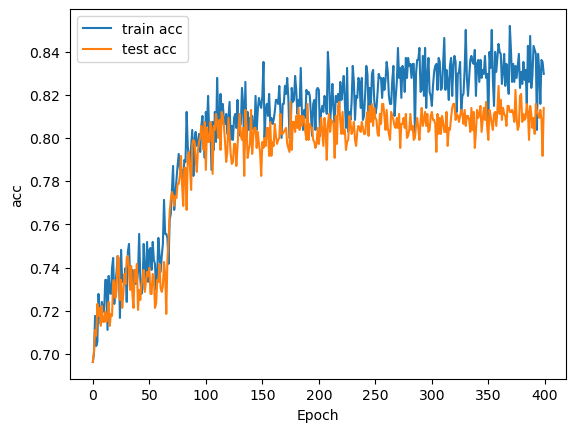

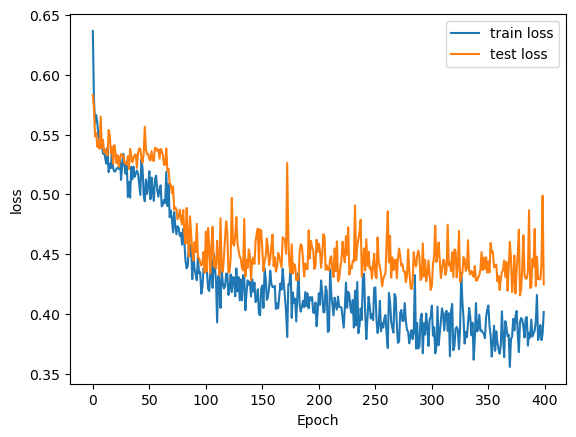

In [12]:
draw_acc_history(history)
draw_loss_history(history)
torch.save(history, f"./{config['model_name']}_history.ckpt")

In [13]:

model_best = config["model"].to(device)
model_best.load_state_dict(torch.load(f"./{config['model_name']}_best.ckpt"))
model_best.eval()


with torch.no_grad():

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= config["learning_rate"])

    batch_test_acc = []
    batch_test_loss = []
    
    for batch in tqdm(test_loader):
        features, labels = batch
        labels = labels.to(device)
        test_pred = model_best(features.to(device))
        loss = criterion(test_pred, labels.long()) 
        acc = (test_pred.argmax(dim= -1)== labels).float().mean()
        batch_test_acc.append(acc)
        batch_test_loss.append(loss.item())

    test_acc = sum(batch_test_acc) / len(batch_test_acc)
    test_loss = sum(batch_test_loss) / len(batch_test_loss)

    print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")
        


  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:00<00:00, 506.79it/s]

[ Test ] loss = 0.43193, acc = 0.82407
